# CONFIGURATION:

In [1]:
from jaad_data import JAAD
import torch
from PIL import Image
from torchvision import transforms
from torchvision import models
import matplotlib.pyplot as plt
import network
import openpose
from openpose import model
from openpose import util
from openpose.body import Body
import copy

import pickle
from torch.utils.data import Dataset, DataLoader
import numpy as np
import cv2
import torch.nn.functional as F

In [2]:
JAAD_PATH = '../JAAD'
DEEPLAB_PATH = '../best_deeplabv3plus_resnet101_cityscapes_os16.pth'
SUBSET_PATH = '../subset'
FILENAME_SUB = '../masks_results_sub.pkl'
FILENAME_BIG = '../masks_results_big.pkl'
POSE_PATH = '../body_pose_model.pth'   


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
torch.cuda.empty_cache()


cuda


In [4]:
RUN =True

# DATASET

In [5]:
# Load the JAAD dataset
jaad_dt = JAAD(data_path=SUBSET_PATH)
#jaad.generate_database()
#jaad_dt.get_data_stats()

data_opts = {
    'fstride': 10,
    'sample_type': 'beh'
}

seq_train = jaad_dt.generate_data_trajectory_sequence('train', **data_opts)  
seq_test = jaad_dt.generate_data_trajectory_sequence('test', **data_opts)  

---------------------------------------------------------
Generating action sequence data
fstride: 10
sample_type: beh
subset: default
height_rng: [0, inf]
squarify_ratio: 0
data_split_type: default
seq_type: intention
min_track_size: 15
random_params: {'ratios': None, 'val_data': True, 'regen_data': False}
kfold_params: {'num_folds': 5, 'fold': 1}
---------------------------------------------------------
Generating database for jaad
jaad database loaded from c:\Users\jacop\Documents\ComputerVision\subset\data_cache\jaad_database.pkl
---------------------------------------------------------
Generating intention data
Split: train
Number of pedestrians: 4 
Total number of samples: 2 
---------------------------------------------------------
Generating action sequence data
fstride: 10
sample_type: beh
subset: default
height_rng: [0, inf]
squarify_ratio: 0
data_split_type: default
seq_type: intention
min_track_size: 15
random_params: {'ratios': None, 'val_data': True, 'regen_data': False}


In [6]:
print('Train sequences:', len(seq_train['image'][0][0]))

Train sequences: 37


In [7]:
train_transforms = transforms.Compose([
    transforms.Resize((512, 512)),  # Ridimensiona le immagini a 256x256
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [8]:
# Trasformazioni per le immagini
transform_lc = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# GLOBAL CONTEXT EXTRACTION:

In [9]:
if RUN:
    deeplab_model = network.modeling.__dict__['deeplabv3plus_resnet101'](num_classes=19)
    deeplab_model.load_state_dict(torch.load(DEEPLAB_PATH)['model_state'])
    deeplab_model.to(device)
    deeplab_model.eval()

In [10]:
def get_segmentation_mask(image_path, model, preprocess):
    # Load the image
    input_image = Image.open(image_path).convert("RGB")
    input_tensor = preprocess(input_image).to(device)
    input_batch = input_tensor.unsqueeze(0)  # Create a batch with a single image
    
    # Pass the image through the model
    with torch.no_grad():
        output = model(input_batch)
        
    # Check if output is a tensor or a dictionary
    if isinstance(output, dict):
        output = output['out'][0]
    elif isinstance(output, torch.Tensor):
        output = output[0]
    else:
        raise ValueError(f"Unexpected output type: {type(output)}")
    
    # Convert the output to a mask
    output_predictions = output.argmax(0)
    # Aggiungi una dimensione batch e canale alla maschera per il ridimensionamento
    output_predictions = output_predictions.unsqueeze(0).unsqueeze(0).float()
    print(output_predictions.shape)
    tr = transforms.ToPILImage()
    mask_img = tr(output_predictions.squeeze(1))
    resized_mask = mask_img.resize((224, 224))
    resized_mask = mask_img.convert('RGB')
        # Ridimensiona la maschera a 224x224
    #resized_mask = F.interpolate(output_predictions, size=(224, 224), mode='nearest')

    # Rimuovi le dimensioni batch e canale
    #resized_mask = resized_mask.squeeze(1).long().cpu()
    plt.imshow(resized_mask)
    plt.show()
    tr2= transforms.Compose([transforms.PILToTensor()])
    resized_mask = tr2(resized_mask)
    return resized_mask

In [11]:
def process_video_frames(seq_train, model, preprocess):
    all_masks = []
    for video_frames in seq_train['image']:
        video_masks = []

        for frame_path in video_frames:
            mask = get_segmentation_mask(frame_path, model, preprocess)
            #visualize_mask(frame_path, mask)
            video_masks.append(mask)
        all_masks.append(video_masks)
    return all_masks

In [12]:
# Visualizza la maschera semantica
def visualize_mask(image_path, mask):
    image = Image.open(image_path).convert("RGB")
    image = image.resize((256, 256))  # Ridimensiona per la visualizzazione
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='jet')
    plt.title("Semantic Mask")
    plt.show()


torch.Size([1, 1, 512, 512])


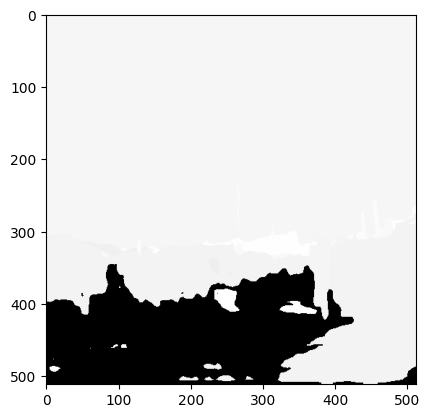

torch.Size([1, 1, 512, 512])


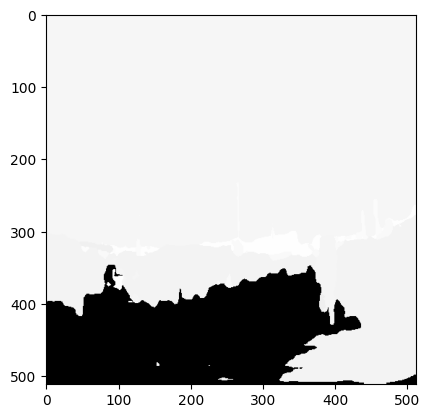

torch.Size([1, 1, 512, 512])


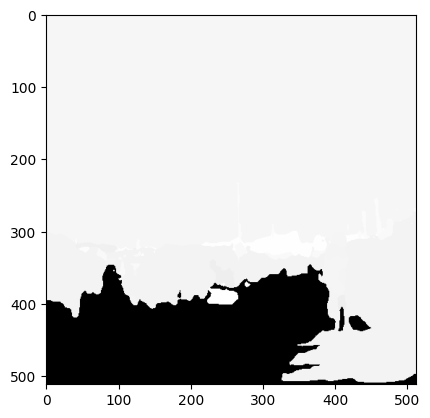

torch.Size([1, 1, 512, 512])


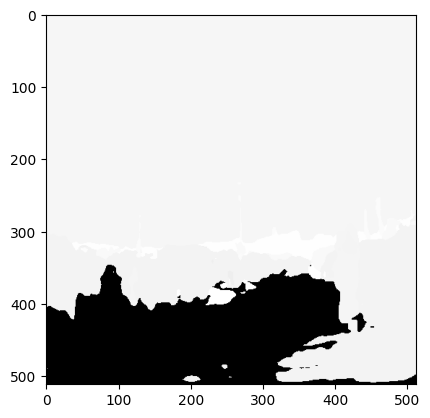

torch.Size([1, 1, 512, 512])


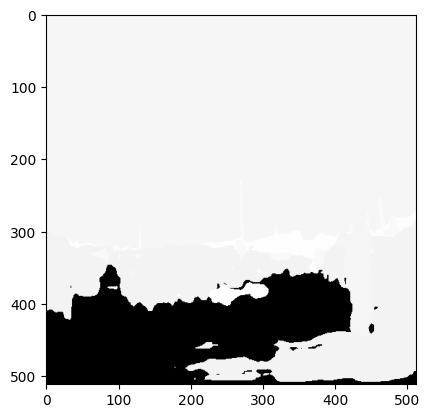

torch.Size([1, 1, 512, 512])


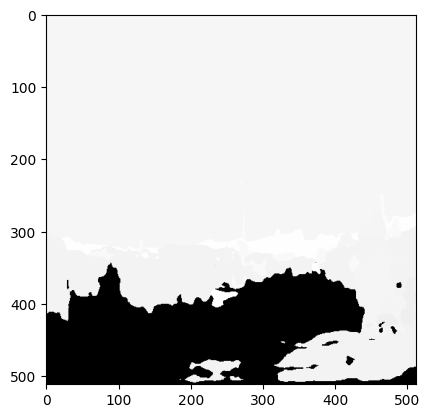

torch.Size([1, 1, 512, 512])


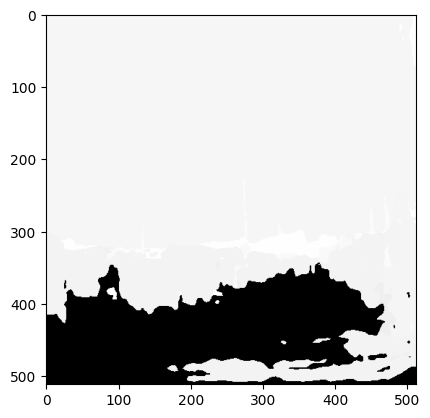

torch.Size([1, 1, 512, 512])


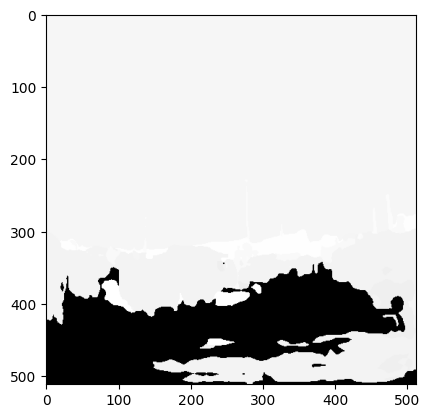

torch.Size([1, 1, 512, 512])


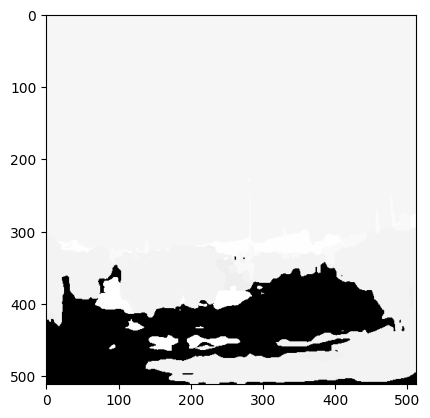

torch.Size([1, 1, 512, 512])


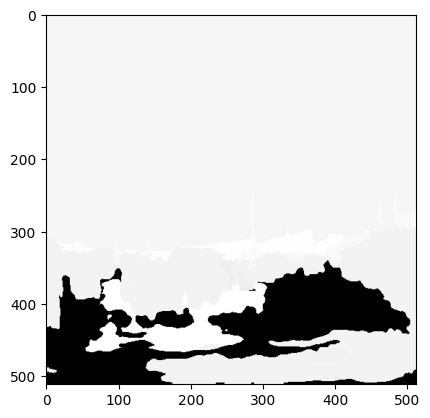

torch.Size([1, 1, 512, 512])


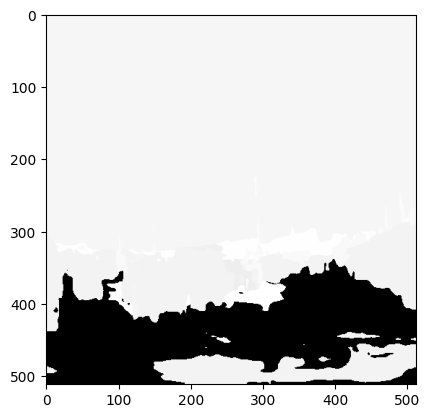

torch.Size([1, 1, 512, 512])


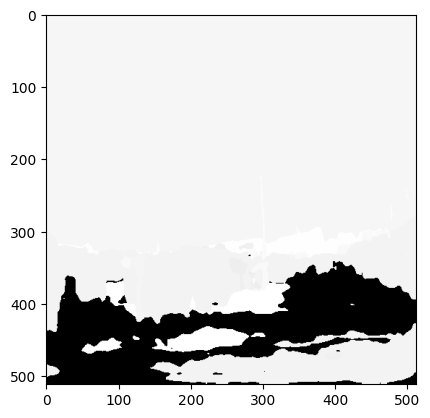

torch.Size([1, 1, 512, 512])


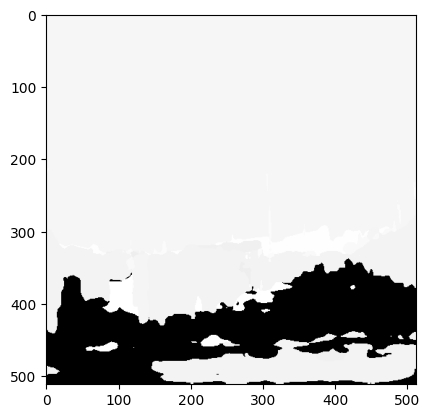

torch.Size([1, 1, 512, 512])


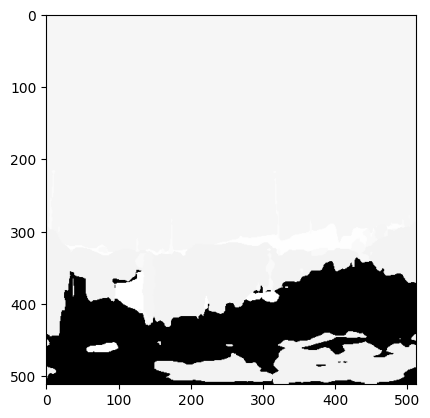

torch.Size([1, 1, 512, 512])


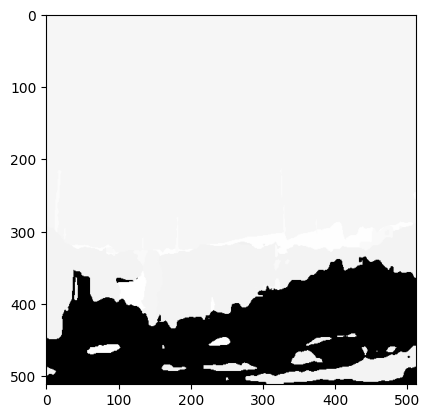

torch.Size([1, 1, 512, 512])


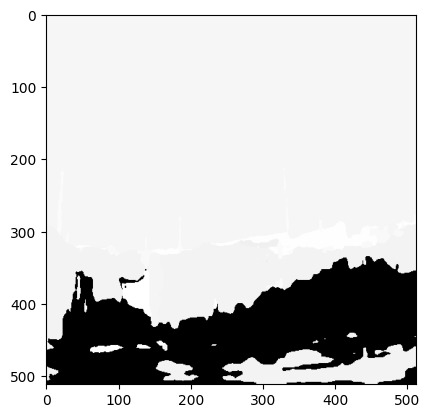

torch.Size([1, 1, 512, 512])


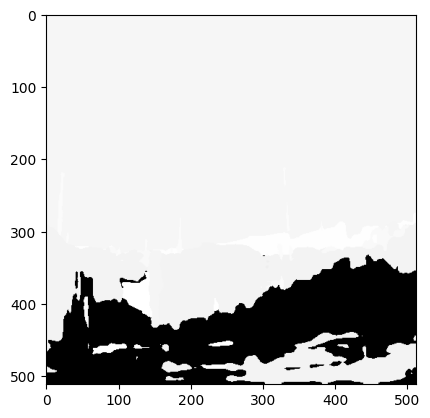

torch.Size([1, 1, 512, 512])


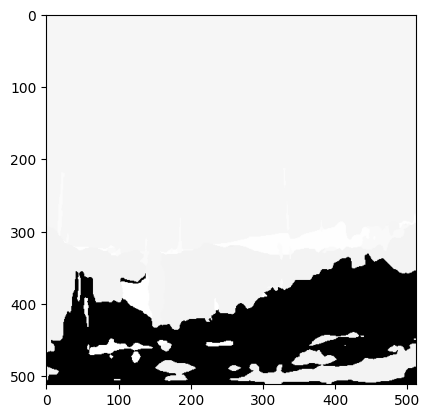

torch.Size([1, 1, 512, 512])


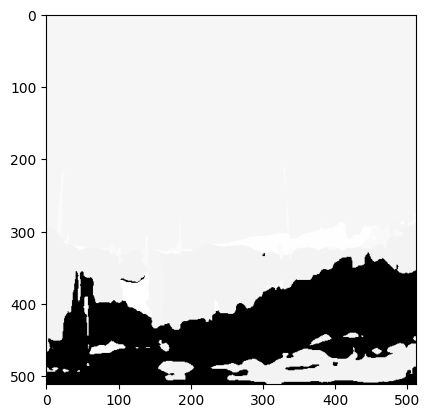

torch.Size([1, 1, 512, 512])


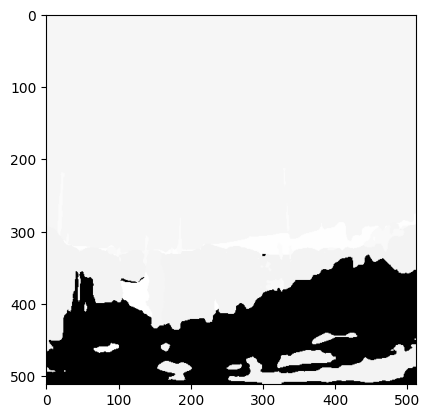

torch.Size([1, 1, 512, 512])


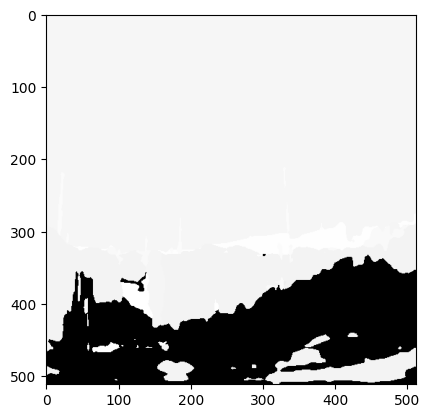

torch.Size([1, 1, 512, 512])


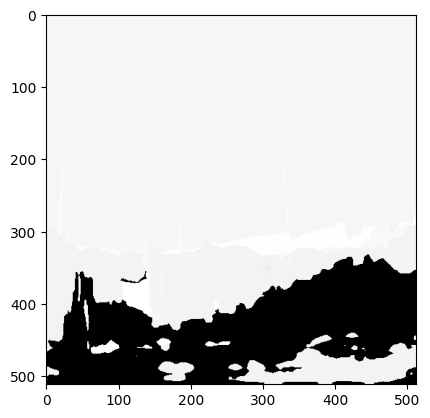

torch.Size([1, 1, 512, 512])


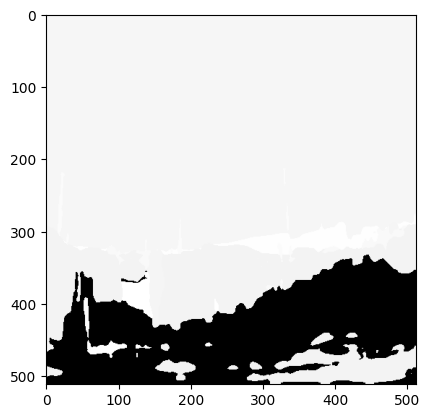

torch.Size([1, 1, 512, 512])


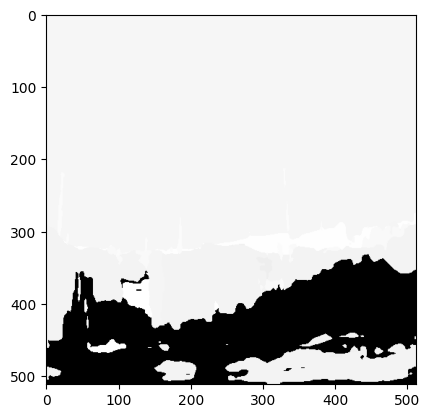

torch.Size([1, 1, 512, 512])


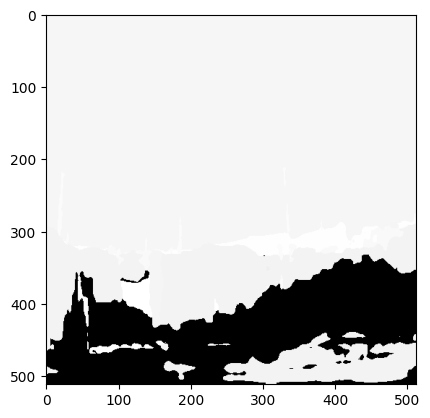

torch.Size([1, 1, 512, 512])


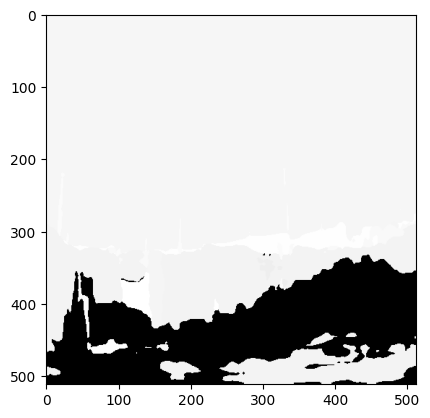

torch.Size([1, 1, 512, 512])


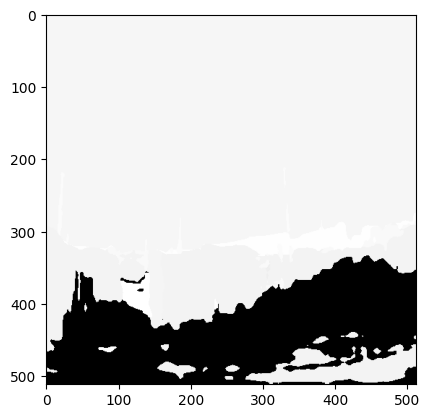

torch.Size([1, 1, 512, 512])


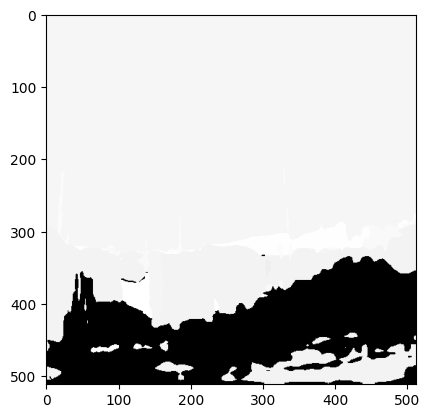

torch.Size([1, 1, 512, 512])


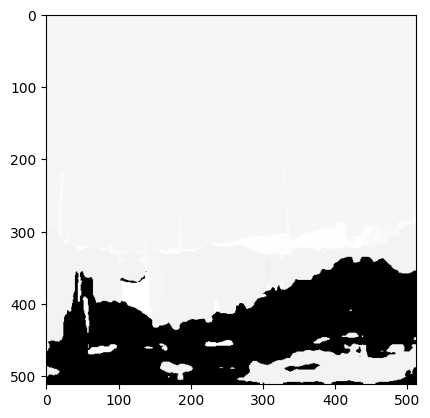

torch.Size([1, 1, 512, 512])


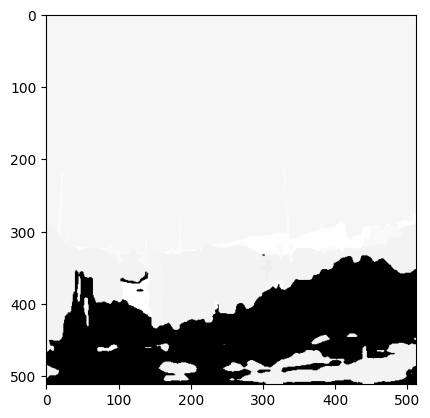

torch.Size([1, 1, 512, 512])


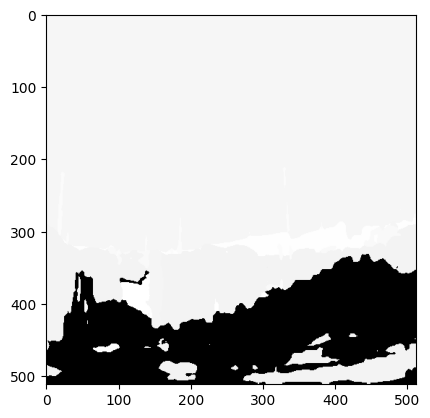

torch.Size([1, 1, 512, 512])


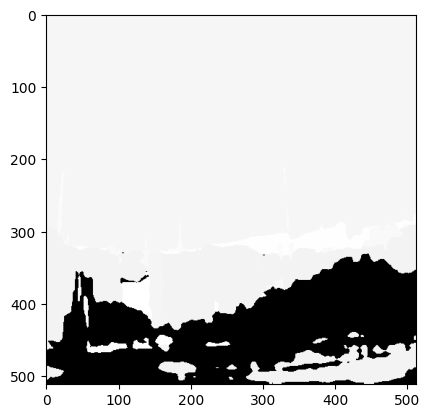

torch.Size([1, 1, 512, 512])


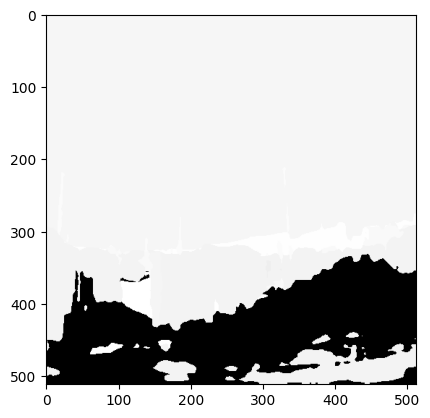

torch.Size([1, 1, 512, 512])


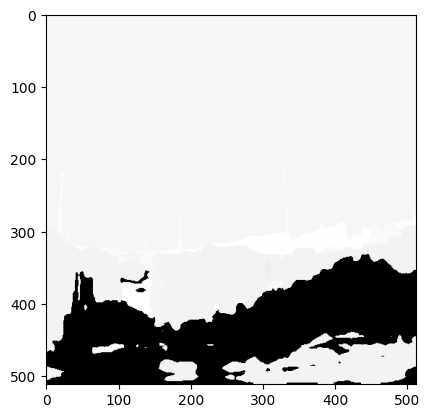

torch.Size([1, 1, 512, 512])


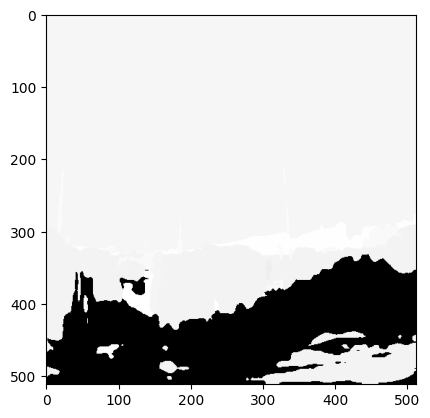

torch.Size([1, 1, 512, 512])


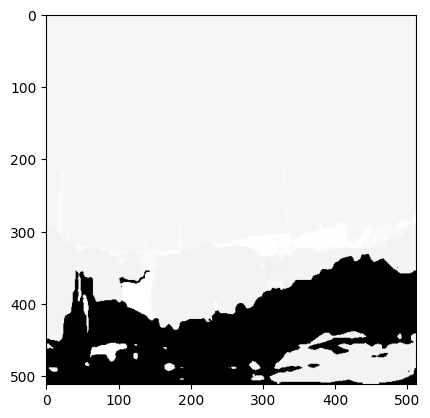

torch.Size([1, 1, 512, 512])


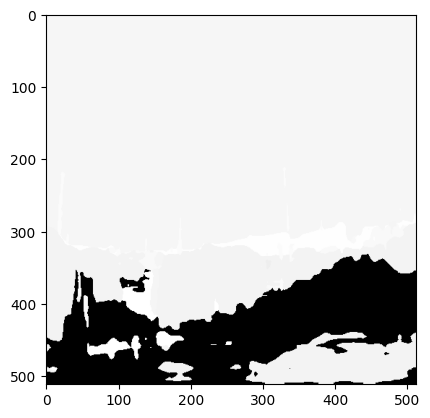

torch.Size([1, 1, 512, 512])


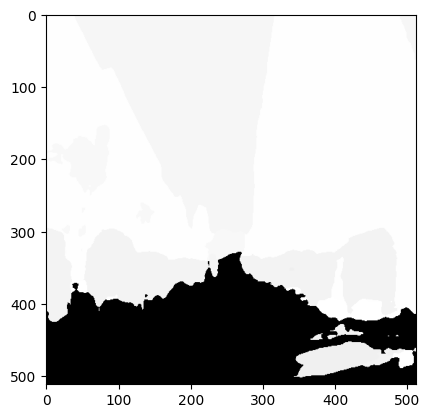

torch.Size([1, 1, 512, 512])


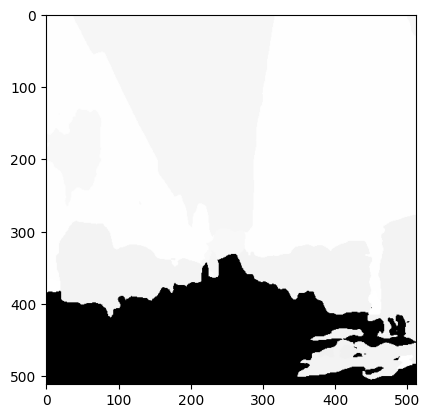

torch.Size([1, 1, 512, 512])


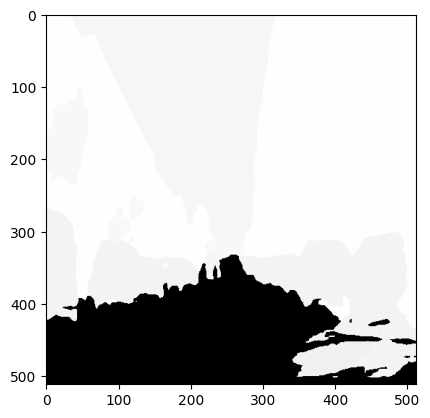

torch.Size([1, 1, 512, 512])


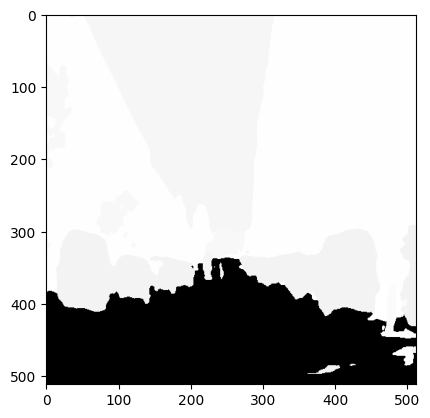

torch.Size([1, 1, 512, 512])


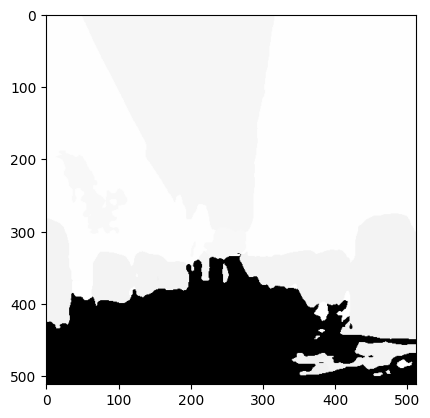

torch.Size([1, 1, 512, 512])


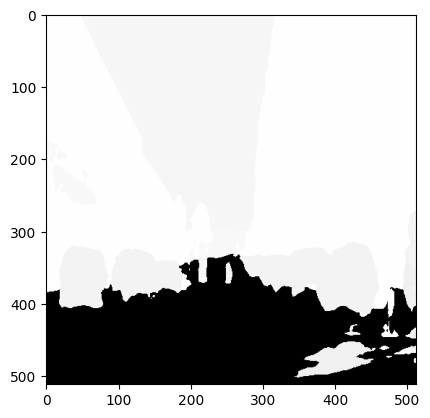

torch.Size([1, 1, 512, 512])


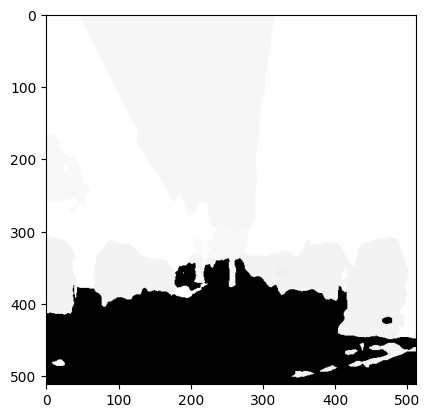

torch.Size([1, 1, 512, 512])


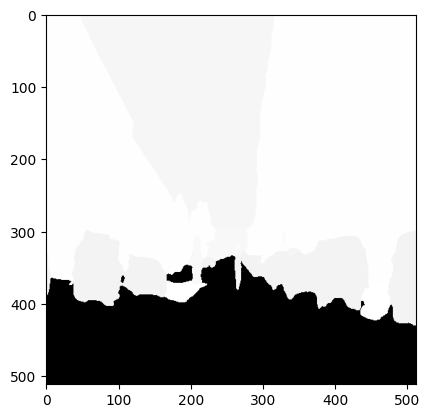

torch.Size([1, 1, 512, 512])


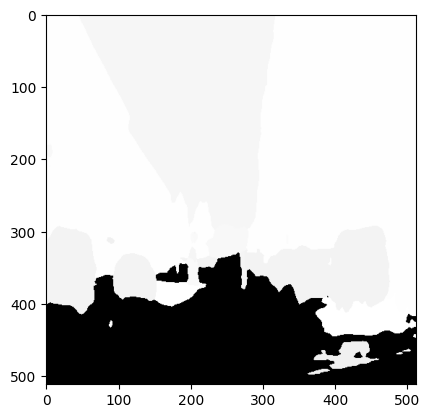

torch.Size([1, 1, 512, 512])


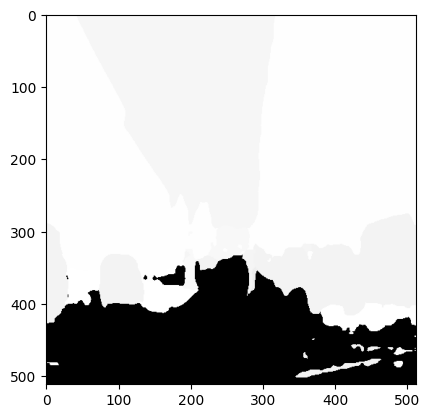

torch.Size([1, 1, 512, 512])


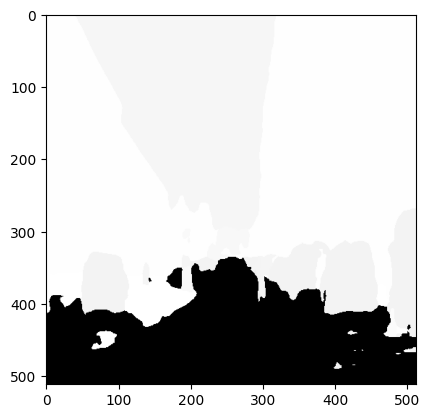

torch.Size([1, 1, 512, 512])


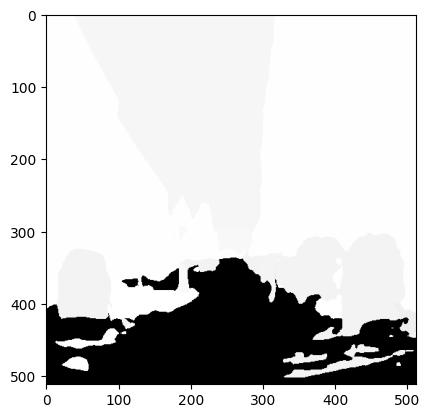

torch.Size([1, 1, 512, 512])


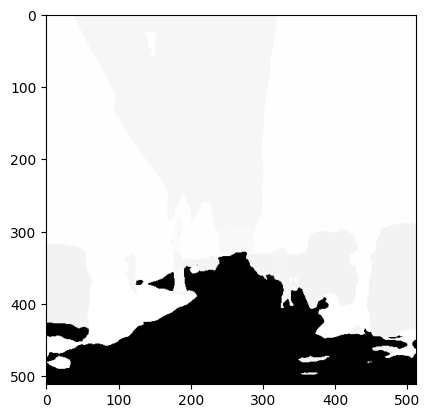

torch.Size([1, 1, 512, 512])


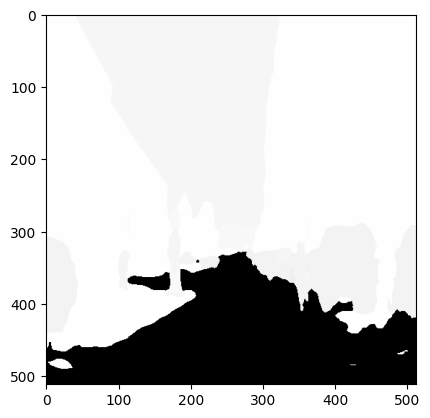

torch.Size([1, 1, 512, 512])


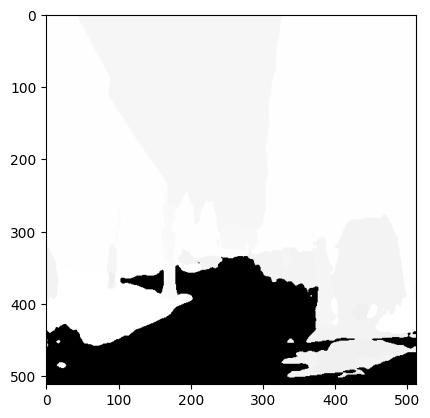

torch.Size([1, 1, 512, 512])


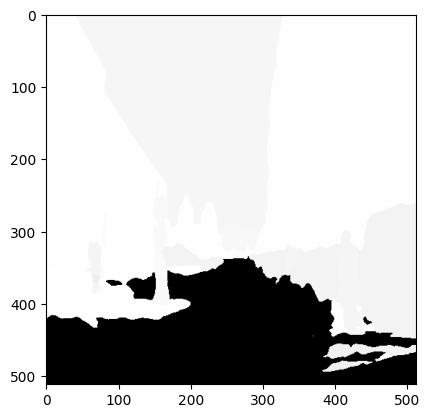

torch.Size([1, 1, 512, 512])


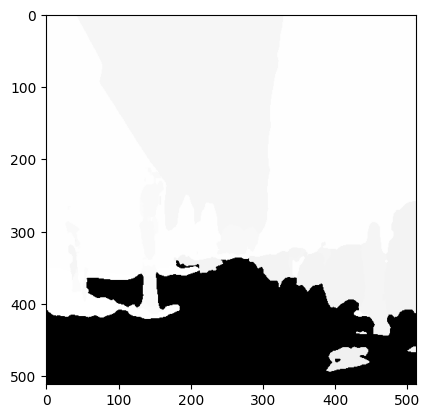

torch.Size([1, 1, 512, 512])


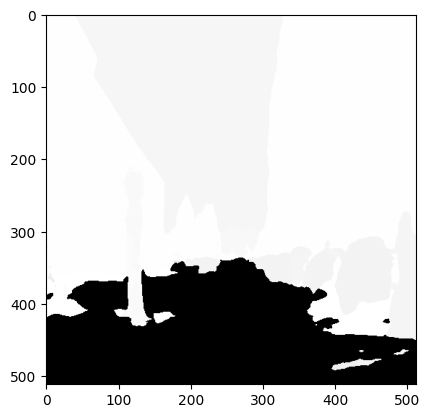

In [13]:
if RUN:
    all_video_masks = process_video_frames(seq_train, deeplab_model, train_transforms)
    seq_train['masks'] = all_video_masks
    # Apri il file in modalità scrittura binaria e salva il dizionario
    with open(FILENAME_SUB, 'wb') as f:
        pickle.dump(seq_train['masks'], f)
else:
    #recover data:
    with open(FILENAME_SUB, 'rb') as f:
        seq_train['masks'] = pickle.load(f)

    # Verifica che i risultati siano stati caricati correttamente
    print(seq_train['masks'])

# LOCAL CONTEXT:

In [14]:
# crop frames arround bounding boxes
def crop_image(img, bbox):
    x1, y1, x2, y2 = bbox
    return img.crop((x1, y1, x2, y2))

<class 'list'>
<PIL.Image.Image image mode=RGB size=68x118 at 0x15B04C7BB50>


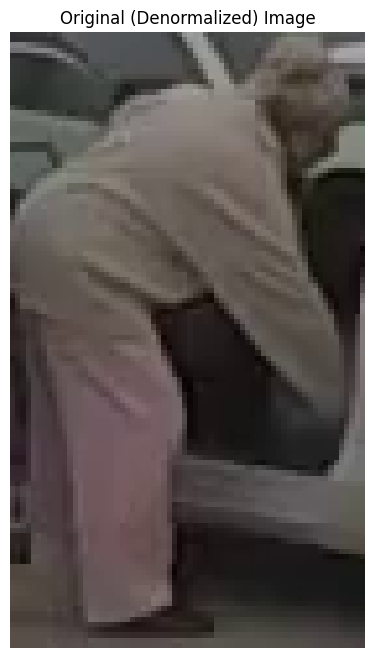

In [15]:
all_images = []
for i in range(seq_train['image'].__len__()):
    aux_list = []
    for j in range(seq_train['image'][i].__len__()):
        #open the images from the paths 
        img_path = seq_train['image'][i][j]
        img = Image.open(img_path).convert("RGB")
        bbox = seq_train['bbox'][i][j]
        #compute local context cropping images arroun the bboxes
        cropped_images = crop_image(img, bbox) 
        aux_list.append(cropped_images)
    all_images.append(aux_list)
print(type(all_images))
print(all_images[0][0])
plt.figure(figsize=(8, 8))
plt.imshow(all_images[0][0])
plt.axis('off')
plt.title("Original (Denormalized) Image")
plt.show()


# POSE KEYPOINTS: 

In [16]:
body_estimation = Body('../body_pose_model.pth')
test_image = 'pic3.png'
oriImg = cv2.imread(test_image)  # B,G,R order
candidate, subset = body_estimation(oriImg)
canvas = copy.deepcopy(oriImg)
canvas = util.draw_bodypose(canvas, candidate, subset)

c:\Users\jacop\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


In [17]:
def extract_pose_sequence(frames,body_model):
    pose_sequences = []  # Lista di pose per ciascuna persona nel tempo
    for frame in frames:
        candidate, subset = body_model(frame)
        frame_poses = []
        for person in subset:
            if person[-1] >= 4:  # Almeno 4 punti chiave rilevati
                pose = []
                for i in range(18):
                    if person[i] != -1:
                        x, y = candidate[int(person[i])][:2]
                    else:
                        x, y = -1, -1  # Punti chiave mancanti
                    pose.extend([x, y])
                frame_poses.append(pose)
        
        pose_sequences.append(frame_poses)

    # Trasponi la lista di liste per ottenere le sequenze temporali per ciascuna persona
    # Cioè da [[pose_frame1_person1, pose_frame1_person2, ...], [pose_frame2_person1, pose_frame2_person2, ...], ...]
    # a [[pose_frame1_person1, pose_frame2_person1, ...], [pose_frame1_person2, pose_frame2_person2, ...], ...]
    person_pose_sequences = list(map(list, zip(*pose_sequences)))

    person_pose_sequences = [torch.tensor(person_poses, dtype=torch.float32) for person_poses in person_pose_sequences]
    return person_pose_sequences
    
# Caricamento del modello
body_model = Body(POSE_PATH)

# Caricamento dei frame (qui puoi sostituire con il tuo metodo di caricamento dei frame)
all_poses =[]
    
for pics in all_images:
    list_aux =[]
# Estrazione delle pose
    for pic in pics:
        img_np = np.array(pic)

# Converti i canali di colore da RGB a BGR se necessario
        img_cv2 = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)
        list_aux.append(img_cv2)
    pose_sequences = extract_pose_sequence(list_aux,body_model)
    print("len pose seq",len(pose_sequences))
    print("pose seq:",pose_sequences)
    all_poses.append(pose_sequences)
print("LEN ALL POSES:", len(all_poses))
seq_train['poses'] = all_poses


len pose seq 1
pose seq: [tensor([[-1., -1., 40.,  ..., 13., -1., -1.],
        [68., 12., 44.,  ...,  9., -1., -1.],
        [72., 21., 43.,  ..., 15., -1., -1.],
        ...,
        [34., 28., 47.,  ..., -1., 49., 22.],
        [34., 31., 48.,  ..., -1., 51., 24.],
        [26., 28., 43.,  ..., -1., 44., 22.]])]
len pose seq 0
pose seq: []
LEN ALL POSES: 2


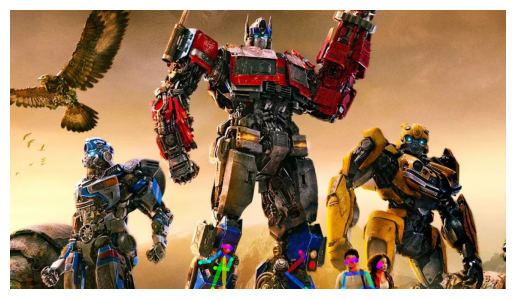

In [18]:

plt.imshow(canvas[:, :, [2, 1, 0]])
plt.axis('off')
plt.show()

# MODEL:

In [19]:
class VisionBranchLocal(torch.nn.Module):
    def __init__(self, vgg16):
        super(VisionBranchLocal, self).__init__()
        self.vgg16 = vgg16
        self.avgpool = torch.nn.AvgPool2d(kernel_size=14)  # Pooling layer con kernel 14x14
        self.gru = torch.nn.GRU(input_size=512, hidden_size=256, num_layers=2, batch_first=True)
        self.fc = torch.nn.Linear(256, 2)  # Output: crossing or not crossing
        self.attn = torch.nn.Linear(256, 1)  # Attention layer
        self.tanh = torch.nn.Tanh()

    def forward(self, cropped_images):
        seq_len, c, h, w = cropped_images.size()
        
        # Estrai feature dalle immagini con VGG19
        vgg_features = []
        for i in range(seq_len):            

            img = cropped_images[i]            
            vgg_feat_img = self.vgg16.features(img)
            pooled_feat_img = self.avgpool(vgg_feat_img)  # Applica il pooling
            vgg_feat_img = pooled_feat_img.view(pooled_feat_img.size(0), -1)  # Flatten features
            vgg_features.append(vgg_feat_img)
        
        vgg_features = torch.stack(vgg_features, dim=1).permute(2,1,0)

        print("SIZE1:",vgg_features.shape)
        gru_out, _ = self.gru(vgg_features)
        print("SIZE1:",gru_out.shape)
        attn_weights = torch.softmax(self.attn(gru_out), dim=1)
        print("SIZE1:",attn_weights.shape) 
        context_vector = torch.sum(attn_weights * gru_out, dim=1)
        print("SIZE1:",context_vector.shape)
        #out = self.sigmoid(self.fc(gru_out[:, -1, :]))   
        out = self.tanh((context_vector))
        return out


In [20]:
class VisionBranchGlobal(torch.nn.Module):
    def __init__(self, vgg16):
        super(VisionBranchGlobal, self).__init__()
        self.vgg16 = vgg16
        self.avgpool = torch.nn.AvgPool2d(kernel_size=14)  # Pooling layer con kernel 14x14
        self.gru = torch.nn.GRU(input_size=512, hidden_size=256, num_layers=2, batch_first=True)
        self.fc = torch.nn.Linear(256, 2)  # Output: crossing or not crossing
        self.attn = torch.nn.Linear(256, 1)  # Attention layer
        self.tanh = torch.nn.Tanh()

    def forward(self, masks):
        seq_len = masks.size()[0]
        print("size forward:",seq_len)
        # Estrai feature dalle immagini con VGG19
        vgg_features = []
        for i in range(seq_len):            

            img = masks[i]            
            vgg_feat_img = self.vgg16.features(img)
            print("passa")
            pooled_feat_img = self.avgpool(vgg_feat_img)  # Applica il pooling
            vgg_feat_img = pooled_feat_img.view(pooled_feat_img.size(0), -1)  # Flatten features
            vgg_features.append(vgg_feat_img)
        
        vgg_features = torch.stack(vgg_features, dim=1).permute(2,1,0)

        print("SIZE2:",vgg_features.shape)
        gru_out, _ = self.gru(vgg_features)
        print("SIZE2:",gru_out.shape)
        attn_weights = torch.softmax(self.attn(gru_out), dim=1)
        print("SIZE2:",attn_weights.shape) 
        context_vector = torch.sum(attn_weights * gru_out, dim=1)
        print("SIZE2:",context_vector.shape)
        out = self.tanh((context_vector))
        return out


In [21]:
class NVisionBranch(torch.nn.Module):
    def __init__(self):
        super(NVisionBranch, self).__init__()
        self.gru = torch.nn.GRU(input_size=36, hidden_size=256, num_layers=2, batch_first=True)
        self.gru2 = torch.nn.GRU(input_size=256+4, hidden_size=256, num_layers=2, batch_first=True)
        self.fc = torch.nn.Linear(256, 2)  # Output: crossing or not crossing
        self.attn = torch.nn.Linear(256, 1)  # Attention layer
        self.tanh = torch.nn.Tanh()

    def forward(self, pose,bbox):
        gru_out, _ = self.gru(pose)
        print("SIZE:",gru_out.shape)
        LP = torch.cat(gru_out,bbox)
        gru_out, _ = self.gru2(LP)
        print("SIZE:",gru_out.shape)
        attn_weights = torch.softmax(self.attn(gru_out), dim=1)
        print("SIZE:",attn_weights.shape) 
        context_vector = torch.sum(attn_weights * gru_out, dim=1)
        print("SIZE:",context_vector.shape)
        #out = self.sigmoid(self.fc(gru_out[:, -1, :]))   
        out = self.tanh((context_vector))
        return out


In [22]:
class PedestrianIntentModel(torch.nn.Module):
    def __init__(self, vision_branch_local,vision_branch_global,non_vision_branch):
        super(PedestrianIntentModel, self).__init__()
        self.vision_branch_local = vision_branch_local
        self.vision_branch_global = vision_branch_global
        self.non_vision_branch = non_vision_branch
        self.fc = torch.nn.Linear(256, 2) # Output: crossing or not crossing
        self.sigmoid = torch.nn.Sigmoid()
    def forward(self, cropped_images, bboxes,masks,poses):
        vision_out_local = self.vision_branch_local(cropped_images)
        vision_out_global = self.vision_branch_global(masks)
        non_vision_out = self.non_vision_branch(poses,bboxes)

        vision_out = torch.cat((vision_out_local, vision_out_global), dim=-1)
        final_fusion = torch.cat((vision_out, non_vision_out), dim=-1)

        attn_weights = torch.softmax(self.attn(final_fusion), dim=1)
        print("SIZE tot:",attn_weights.shape) 
        context_vector = torch.sum(attn_weights * final_fusion, dim=1)

        out = self.sigmoid(self.fc(context_vector))
        return out

In [23]:
class VGG16_FeatureExtractor(torch.nn.Module):
    def __init__(self):
        super(VGG16_FeatureExtractor, self).__init__()
        self.features = torch.nn.Sequential(*list(vgg16.features.children())[:24]) # block4_pool è il 23° livello
    
    def forward(self, x):
        x = self.features(x)
        return x

In [24]:
# Carica il modello VGG19 pre-addestrato
vgg16 = models.vgg16(pretrained=True)

#cut the model at the 24th layer:
vgg16_fe = VGG16_FeatureExtractor()
vgg16_fe


# define the models of the branches
model_local = VisionBranchLocal(vgg16_fe).to(device)
model_global = VisionBranchGlobal(vgg16_fe).to(device)
model_non_vision = NVisionBranch().to(device)
model = PedestrianIntentModel(model_local,model_global,model_non_vision).to(device)


c:\Users\jacop\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\jacop\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# DATASET & DATALOADER

In [25]:
class JAADDataset(Dataset):
    def __init__(self, seq_data, all_images, transform=None):
        self.seq_data = seq_data
        self.all_images = all_images
        self.transform = transform

    def __len__(self):
        return len(self.seq_data['image'])

    def __getitem__(self, idx):
        # Carica le immagini e le maschere
        #get path of images
        #img_paths = self.seq_data['image'][idx]
        #get bboxes 
        bbox_sequence = self.seq_data['bbox'][idx]
        masks = self.seq_data['masks'][idx]
        poses = self.seq_data['poses'][idx]
        all_images = self.all_images[idx]
        #open the images from the paths 
        #images = [Image.open(img_path).convert("RGB") for img_path in img_paths]

        #compute local context cropping images arroun the bboxes
        #cropped_images = [crop_image(img, bbox) for img, bbox in zip(images, bbox_sequence)]

        #mask_paths = self.seq_data['masks'][idx]

        #masks = [Image.fromarray(mask.numpy()) for mask in mask_paths]
        if self.transform:
            #images = [self.transform(img) for img in images]
            cropped_images = [self.transform(img) for img in all_images]
            #
            #masks = [mask.Resize(224, 224) for mask in masks]

        bboxes = torch.tensor(self.seq_data['bbox'][idx], dtype=torch.float32)
        intents = torch.tensor(self.seq_data['intent'][idx], dtype=torch.long)
        return  cropped_images, bboxes, masks, poses, intents

In [26]:
train_dataset = JAADDataset(seq_train,all_images=all_images, transform=transform_lc)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

# TRAINING:

In [27]:
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

In [28]:
def denormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

In [29]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
def show_pic(image):    
    numpy_data = image.cpu().numpy()

    # Create a new figure
    plt.figure(figsize=(8, 8))

    # Display the image
    plt.imshow(numpy_data)  # Use 'gray' colormap for grayscale images

    # Remove axes ticks
    plt.axis('off')

    # Add a title if needed
    plt.title("Your Image Title")

    # Show the plot
    plt.show()

([tensor([[[-1.2617, -1.2617, -1.2617,  ..., -0.7479, -0.7650, -0.7650],
         [-1.2788, -1.2788, -1.2788,  ..., -0.7479, -0.7479, -0.7479],
         [-1.2959, -1.2959, -1.2959,  ..., -0.7308, -0.7308, -0.7308],
         ...,
         [-0.6109, -0.6109, -0.6109,  ..., -0.9192, -0.9192, -0.9192],
         [-0.6109, -0.6109, -0.6109,  ..., -0.9020, -0.9020, -0.9020],
         [-0.6109, -0.6109, -0.6109,  ..., -0.8849, -0.8849, -0.8849]],

        [[-1.1779, -1.1779, -1.1779,  ..., -0.5651, -0.5826, -0.5826],
         [-1.1954, -1.1954, -1.1954,  ..., -0.5651, -0.5651, -0.5651],
         [-1.2129, -1.2129, -1.2129,  ..., -0.5476, -0.5476, -0.5476],
         ...,
         [-0.6527, -0.6527, -0.6527,  ..., -0.8978, -0.8978, -0.8978],
         [-0.6527, -0.6527, -0.6527,  ..., -0.8803, -0.8803, -0.8803],
         [-0.6527, -0.6527, -0.6527,  ..., -0.8627, -0.8627, -0.8627]],

        [[-0.8981, -0.8981, -0.8981,  ..., -0.3055, -0.3230, -0.3230],
         [-0.9156, -0.9156, -0.9156,  ..., 

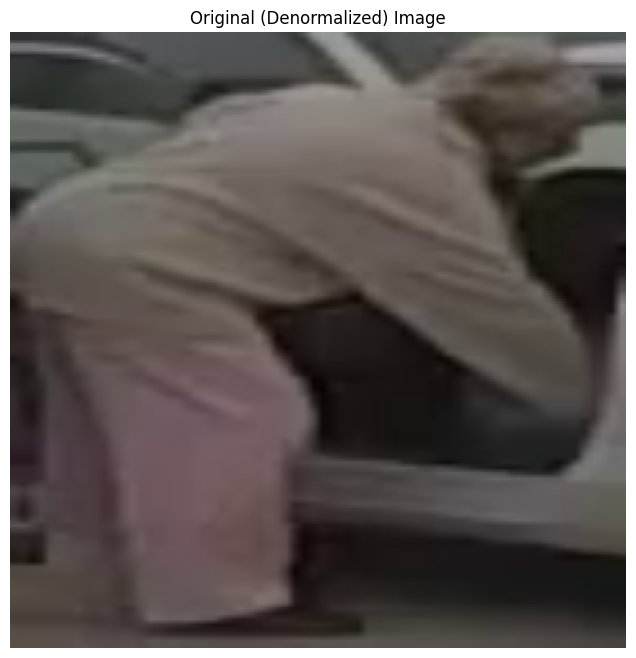

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9831933..1.1410894].


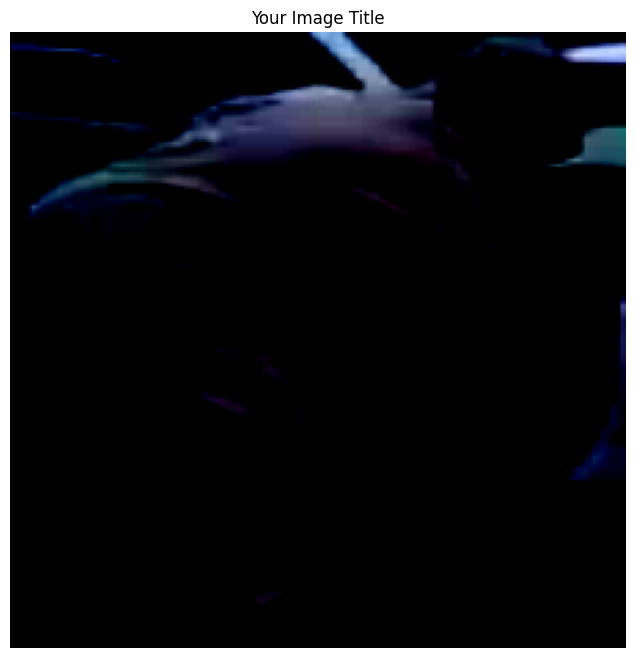

In [30]:
print(train_dataset.__getitem__(0))
print(len(train_dataset))
print(train_dataset.__getitem__(0)[1][0])
denormalized_tensor = denormalize(train_dataset.__getitem__(0)[0][0].clone(), mean, std)
if denormalized_tensor.dim() == 3:
    img_np = denormalized_tensor.permute(1, 2, 0).cpu().numpy()
elif denormalized_tensor.dim() == 4:
    img_np = denormalized_tensor[0].permute(1, 2, 0).cpu().numpy()

# Clip values to [0, 1] range
img_np = np.clip(img_np, 0, 1)

# Plot the image
plt.figure(figsize=(8, 8))
plt.imshow(img_np)
plt.axis('off')
plt.title("Original (Denormalized) Image")
plt.show()
show_pic(train_dataset.__getitem__(0)[0][0].permute(1,2,0))


In [31]:
num_epochs = 10
torch.cuda.empty_cache()

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    model.train()
    for cropped_images, bboxes, masks, poses, intents in train_loader:
        print("TRAINING:")
        print("shape0",len(cropped_images))
        cropped_images = torch.stack(cropped_images, dim=1).squeeze(0).permute(0, 1, 2,3).to(device)  # Converte la lista di immagini in un tensor
        print("shape",cropped_images.shape,masks[0].shape, len(masks))
        masks = torch.stack(masks,dim=1).squeeze(0).float().to(device)  # Converte la lista di maschere in un tensor
        print("shape2",masks.shape)
        print(type(bboxes))
        bboxes = bboxes.to(device)
        print("posa",type(poses))
        print(poses)
        poses = torch.stack(poses, dim=1).squeeze(0).to(device)
        intents = intents.squeeze(0).to(device)
    
        optimizer.zero_grad()
        outputs = model( cropped_images, bboxes,masks,poses)
        loss = criterion(outputs, intents)
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch 1/10
TRAINING:
shape0 18
shape torch.Size([18, 3, 224, 224]) torch.Size([1, 3, 512, 512]) 18
shape2 torch.Size([18, 3, 512, 512])
<class 'torch.Tensor'>
posa <class 'list'>
[]


RuntimeError: stack expects a non-empty TensorList

# las